In [ ]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

<span class="ecb">Comments by ECB</span>

# ATMO 5331 - Homework 2 - Fall 2025
## Due 28 Sep, 2025 (Sunday, 11:59 pm)

When doing this homework, remember that you have three jobs:
1. Make it work and get the right answer.
2. Clean it up so that I can understand what you've done. If you think I might not undersand, document it with a comment or a function docstring.
3. Practice _generalizing_ your thinking: write code that is tolerant of changes to the specifics of a problem, but not the structure of the problem.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring there is an even contribution by your partner.

**Question 1**

Grab the [WGS84 implementation manual](https://www.icao.int/sites/default/files/safety/pbn/External%20References/Eurocontrol-WGS-84-Implementation-Manual.pdf), and implement a translation from geodetic latitude, longitude, and altitude (referenced to the WGS84 ellisoid) to the local XYZ cartesian system used for WGS84.

Use part 1 of Helmert's formula on p. 81 (Appendix E), and refer to Fig. B-6 in Appendix B (p. 70) for information about the coordinate system notation.

Careful with degrees and radians.

Compare your results to what you get when using the `proj4` library. This library has its origins in public domain code written by the USGS, and is used in many open source packages (for example, the QGIS open-source GIS app). For easy use of the `proj4` library, we will use the helper routines in `coords.py`. I use these same helpers all the time in practice. In fact, this code is running in operations in NOAA!

You set up a coordinate system transform object as shown below. It defaults to a WGS84 ellipsoid, so we don't have to specify that. Once the coordinate system object `geo` has been created, you can reuse it withouth calling `GeographicSystem()` again. It accepts arrays of data.

Demonstrate that your ECEF conversion equals that provided by the coordinate system library. For your dataset, please use the `lat`, `lon`, and `alt` given below. 


In [1]:
import numpy as np
from coords import GeographicSystem 

def geodetic_to_ecef(lat_deg, lon_deg, alt_m): 
    """
    Want to convert geodetic coords (lat, lon, alt) from WGS84 to
    Earth-centered Earth Fixed (ECEF) Cartesian coords
    """
    
    # constants from WGS84 
    a= 6378137.0           #semi-major axis of ellipsoid (m)
    f= 1/298.257223563     #flattening of ellipsoid
    e2= f*(2-f)            # eccentricity of ellipsoid squared
    
    # conversion from degrees to radians
    lat= np.radians(lat_deg)
    lon= np.radians(lon_deg)
    h= np.array(alt_m, dtype=float)
    
    # v= radius of curvature in the prime vertical
    v= a/np.sqrt(1- e2* np.sin(lat)**2)
    
    # Equations for ECEF coordinates
    X = (v + h) * np.cos(lat) * np.cos(lon)
    Y = (v + h) * np.cos(lat) * np.sin(lon)
    Z = ((v * (1 - e2)) + h) * np.sin(lat)
    
    return X, Y, Z

lat = np.array([  33.5,   1.0,   0.0,   0.0,   0.0,  10.0, -10.0]) 
lon = np.array([-101.5, -75.0, -85.0, -65.0, -75.0, -75.0, -75.0]) 
alt = np.zeros_like(lat)

# Manual conversion
X_manual, Y_manual, Z_manual= geodetic_to_ecef(lat, lon, alt)

geo = GeographicSystem() 
X_lib, Y_lib, Z_lib = geo.toECEF(lon, lat, alt) # Use degrees

#Comparing manual calculations to the library 
print("Manual:\n", np.vstack([X_manual, Y_manual, Z_manual]).T)
print("Library:\n", np.vstack([X_lib, Y_lib, Z_lib]).T)
print("Difference (manual - library):\n", 
      np.vstack([X_manual - X_lib, Y_manual - Y_lib, Z_manual - Z_lib]).T)

Manual:
 [[-1061448.75418035 -5217187.30723133  3500334.28802236]
 [ 1650533.58831094 -6159875.21117539   110568.77482457]
 [  555891.26758132 -6353866.26310279        0.        ]
 [ 2695517.17208404 -5780555.22988658        0.        ]
 [ 1650783.32787306 -6160807.25190988        0.        ]
 [ 1625868.32721344 -6067823.20357756  1100248.54773536]
 [ 1625868.32721344 -6067823.20357756 -1100248.54773536]]
Library:
 [[-1061448.75418035 -5217187.30723133  3500334.28802236]
 [ 1650533.58831094 -6159875.21117539   110568.77482457]
 [  555891.26758132 -6353866.26310279        0.        ]
 [ 2695517.17208404 -5780555.22988658        0.        ]
 [ 1650783.32787306 -6160807.25190988        0.        ]
 [ 1625868.32721344 -6067823.20357756  1100248.54773536]
 [ 1625868.32721344 -6067823.20357756 -1100248.54773536]]
Difference (manual - library):
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


**Question 2.**

Using the `TangentPlaneCartesianSystem` class, convert the geodetic coordinates to local $(x, y, z)$. Create three tangent planes:

- A tangent plane centered at the MCOM building on the TTU campus, at the height of the ground at that location.

- A tangent plane centered at the MCOM building on the TTU campus, at the ellipsoid.

- A tangent plane directly below the GOES-East satellite at -75.0 degrees longitude.

Use `TangentPlaneCartesianSystem?` in the notebook to learn about the arguments accepted by the projection class. It has the same `.toECEF` and `.fromECEF` methods as the `GeographicSystem`.

Transform the geodetic dataset from the first problem into coordiantes with respect to each tangent plane.

You do not need to use the NAD83 locations of MCOM. They are only there to show my work on how I obtained the vertical position of MCOM in WGS84.

**a.** Using only the GOES-East tangent plane and the transformed geodetic dataset, show that the WGS84 earth shape is not spherical.

**b.** What is a rough, easily memorable rule of thumb for the number of kilometers per degree latitude?

**c.** Print out the tangent plane $(x,y,z)$ of the zeroth data point (it is a bit east of Lubbock). Explain why the differences in the coordinates of the two MCOM tangent planes make sense.

**d.** Imagine that there was no terrain, so that a radar located at MCOM was precisely on the WGS84 ellipsoid. If that radar were to scan toward the zeroth position at 0° elevation angle (assume no atmospheric refraction), how high above the ground would the beam be? Is this disance measured perpendicular to the ellipsoid or perpendicular to the tangent plane?

**e.** Transform your coordiantes back to ECEF from each tangent plane and show they're equal.

In [2]:
import numpy as np
from coords import GeographicSystem, TangentPlaneCartesianSystem

# a. GOES-E tangent plane
#restating lat, lon, alt
lat = np.array([  33.5,   1.0,   0.0,   0.0,   0.0,  10.0, -10.0]) 
lon = np.array([-101.5, -75.0, -85.0, -65.0, -75.0, -75.0, -75.0]) 
alt = np.zeros_like(lat)
geo= GeographicSystem()

# From USGS Elevation point query service
# https://apps.nationalmap.gov/epqs/
# NAD83 lon, lat and NAVD88 vertical
mcom_lat_nad83, mcom_lon_nad83 = 33.581857, -101.880360 # NAD83
mcom_alt_nad83 = 983.15

# Using https://vdatum.noaa.gov/vdatumweb/, convert the above to "WGS84 G1674 (Use ITRF2008)"
mcom_lon, mcom_lat = -101.8803718553, 33.5818617015
mcom_alt = 957.179

# The altitude difference is about the height of the geoid at this location.

# Converting to ECEF
X, Y, Z= geo.toECEF(lon, lat, alt)

#Tangent plane of GOES (TPCS)
tp_goes= TangentPlaneCartesianSystem(0.0, -75.0, 35786000.0)

# Converting geodet to GOES TP 
enu_goes= np.vstack(tp_goes.fromECEF(X, Y, Z)).T

print("Part a)")
for i in range(len(lat)): 
    print(f"Point {i}: lat= {lat[i]}, lon= {lon[i]}, ENU= {enu_goes[i]}")
    
d_lon= np.linalg.norm(enu_goes[2]- enu_goes[3]) /20.0 #km per deg lon
d_lat= np.linalg.norm(enu_goes[5]- enu_goes[6]) /20.0 #km per deg lat

print(f"~km per degree longitude at the equator: {d_lon/1000:.2f} km") # divide by 1000! (km)
print(f"~km per degree latitude at the equator: {d_lat/1000:.2f} km")  # divide by 1000! (km)
print("Therefore, WGS84 earth shape is not perfectly spherical!")

# b. Number of km per deg lat
print("\nPart b)")
km_per_deg_lat= 110.0       # (km)
print(f"Good rule of thumb: ~{km_per_deg_lat} km per degree latitude")

Part a)
Point 0: lat= 33.5, lon= -101.5, ENU= [ -2375588.20197264   3500334.28799429 -37399444.19233947]
Point 1: lat= 1.0, lon= -75.0, ENU= [-8.70788880e-06  1.10568775e+05 -3.57869649e+07]
Point 2: lat= 0.0, lon= -85.0, ENU= [-1.10755187e+06 -1.31570989e-05 -3.58828982e+07]
Point 3: lat= 0.0, lon= -65.0, ENU= [ 1.10755187e+06  1.28748998e-05 -3.58828982e+07]
Point 4: lat= 0.0, lon= -75.0, ENU= [-7.40684462e-06 -1.40718516e-07 -3.57860000e+07]
Point 5: lat= 10.0, lon= -75.0, ENU= [-2.03556117e-05  1.10024855e+06 -3.58822642e+07]
Point 6: lat= -10.0, lon= -75.0, ENU= [ 5.50472918e-06 -1.10024855e+06 -3.58822642e+07]
~km per degree longitude at the equator: 110.76 km
~km per degree latitude at the equator: 110.02 km
Therefore, WGS84 earth shape is not perfectly spherical!

Part b)
Good rule of thumb: ~110.0 km per degree latitude


In [3]:
# c. 
print("Part c)")

# defining tangent planes for MCOM
tp_mcom_ground= TangentPlaneCartesianSystem(mcom_lat, mcom_lon, mcom_alt)
tp_mcom_ellipsoid= TangentPlaneCartesianSystem(mcom_lat, mcom_lon, 0.0)

# Converting data into each tangent plane
enu_mcom_ground= np.vstack(tp_mcom_ground.fromECEF(X, Y, Z)).T
enu_mcom_ellipsoid= np.vstack(tp_mcom_ellipsoid.fromECEF(X, Y, Z)).T


print("ENU (MCOM Ground, 0th point):", enu_mcom_ground[0])
print("ENU (MCOM Ellipsoid, 0th point):", enu_mcom_ellipsoid[0])

#Printing the difference between the two
diff= enu_mcom_ground[0] - enu_mcom_ellipsoid[0]
print("Difference Between the MCOM tangent planes", diff)


# d. 
print("\nPart d)")

# zeroth point in MCOM-ellipsoid frame
target_enu = enu_mcom_ellipsoid[0]   # [E, N, U] (m)

z_target = target_enu[2]             # vertical coordinate of the target (m)
beam_height_above_ground = -z_target # beam at z=0 minus target z

print("Target ENU (MCOM ellipsoid):", target_enu)
print(f"Target z (m): {z_target:.6f}")
print(f"Beam height above ground (m): {beam_height_above_ground:.3f}")

# e. 
print ("\nPart e)")

def round_trip(tp, enu, X_orig, Y_orig, Z_orig, label):
    """
    Transform your coordiantes (ENU local) back to ECEF from each tangent plane (tp.toECEF) 
    and show they're equal (compare with original ECEF).
    """
    
    enu= np.atleast_2d(enu) #shaped (N,3)
    X_rt, Y_rt, Z_rt= tp.toECEF(enu[:, 0], enu[:, 1], enu[:, 2]) #x, y, z arrays for enu
    X_rt= np.atleast_1d(X_rt)           #enu x
    Y_rt= np.atleast_1d(Y_rt)           #enu y
    Z_rt= np.atleast_1d(Z_rt)           #enu z
    X0= np.atleast_1d(X_orig)           #orig x
    Y0= np.atleast_1d(Y_orig)           #orig y
    Z0= np.atleast_1d(Z_orig)           #orig z
    
    # Differences between ENU and orig
    dX= X0-X_rt
    dY= Y0-Y_rt
    dZ= Z0-Z_rt
    max_abs= np.max(np.abs(np.vstack([dX, dY, dZ]))) #max abs values
    rms= np.sqrt(np.mean((dX**2+dY**2+dZ**2)/3.0))   #root mean square eq
    
    
    print(f"Round-trip check: {label}")
    print(f"Maximum Absolute Difference (m): {max_abs:.3e}")
    print(f"RMS per-component (m): {rms:.3e}")
    
    #Allclose to check the round-trip 
    #|ai−bi|≤atol+rtol⋅|bi| where True= all elements meet criteria
    print("Allclose (atol= 1e-6):", np.allclose(np.vstack([X0, Y0, Z0]).T,
                                                np.vstack([X_rt, Y_rt, Z_rt]).T, atol= 1e-6))
    print()
    
    #round trip for each tangent plane
    
round_trip(tp_mcom_ground, enu_mcom_ground, X, Y, Z, "MCOM (ground)")
round_trip(tp_mcom_ellipsoid, enu_mcom_ellipsoid, X, Y, Z, "MCOM (ellipsoid)")
round_trip(tp_goes, enu_goes, X, Y, Z, "GOES-East")

Part c)
ENU (MCOM Ground, 0th point): [35344.86072647 -9014.72096474 -1061.40673583]
ENU (MCOM Ellipsoid, 0th point): [35344.86072647 -9014.72096474  -104.22773583]
Difference Between the MCOM tangent planes [ 3.63797881e-11 -4.83851181e-10 -9.57179000e+02]

Part d)
Target ENU (MCOM ellipsoid): [35344.86072647 -9014.72096474  -104.22773583]
Target z (m): -104.227736
Beam height above ground (m): 104.228

Part e)
Round-trip check: MCOM (ground)
Maximum Absolute Difference (m): 1.723e-08
RMS per-component (m): 7.691e-09
Allclose (atol= 1e-6): True

Round-trip check: MCOM (ellipsoid)
Maximum Absolute Difference (m): 1.816e-08
RMS per-component (m): 8.676e-09
Allclose (atol= 1e-6): True

Round-trip check: GOES-East
Maximum Absolute Difference (m): 1.471e-07
RMS per-component (m): 8.201e-08
Allclose (atol= 1e-6): True



**Question 3** Use the `GeostationaryFixedGridSystem` to define two more coordiante transformations for the GOES-East and GOES-West locations at -75.0 and -135.0 degrees longitude.

Use `GeostationaryFixedGridSystem?` in the notebook to learn about the arguments accepted by the projection class.

Convert the dataset to fixed grid coordinates.

For more on fixed grid coordiantes, you can read the [GOES-R L1b product users' guide](https://www.goes-r.gov/resources/docs.html) and [my own description of GOES fixed grid coordiantes](https://github.com/deeplycloudy/glmtools/blob/master/docs/fixedgridguide.md), a.k.a. [the geostationary projection](https://proj.org/operations/projections/geos.html).



In [4]:
from coords import GeographicSystem, GeostationaryFixedGridSystem

geo= GeographicSystem()

# Converting to ECEF
X, Y, Z = geo.toECEF(lon, lat, alt)

# Defining 2 geostationary fixed grid systems
# geostationary satellite height ~35786000.0 m 
goes_east = GeostationaryFixedGridSystem(subsat_lon=-75.0,
    sweep_axis='x',      
    sat_ecef_height=35785831.0,  # height (m)
    ellipse='WGS84',
    datum='WGS84')

goes_west = GeostationaryFixedGridSystem(subsat_lon=-135.0,
    sweep_axis='x',
    sat_ecef_height=35785831.0,
    ellipse='WGS84',
    datum='WGS84')

# Converting to fixed-grid with GOES projection coords
fg_east = np.vstack(goes_east.fromECEF(X, Y, Z)).T
fg_west = np.vstack(goes_west.fromECEF(X, Y, Z)).T

# Print both arrays
print("GOES-East Fixed Grid (radians):")
print(fg_east)

print("\nGOES-West Fixed Grid (radians):")
print(fg_west)                                 

GOES-East Fixed Grid (radians):
[[-6.31591216e-02  9.33217809e-02  2.60248972e-17]
 [ 0.00000000e+00  3.08964299e-03  2.60248972e-17]
 [-3.08560795e-02  0.00000000e+00 -2.60248972e-17]
 [ 3.08560795e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.06532803e-02  0.00000000e+00]
 [ 0.00000000e+00 -3.06532803e-02  0.00000000e+00]]

GOES-West Fixed Grid (radians):
[[ 7.74072889e-02  9.25223356e-02  2.60248972e-17]
 [ 1.40761845e-01  2.83687991e-03  2.60248972e-17]
 [ 1.27662393e-01  0.00000000e+00 -2.60248972e-17]
 [ 1.48794814e-01  0.00000000e+00  0.00000000e+00]
 [ 1.40785142e-01  0.00000000e+00  0.00000000e+00]
 [ 1.38464436e-01  2.81873831e-02  0.00000000e+00]
 [ 1.38464436e-01 -2.81873831e-02  0.00000000e+00]]


**Question 4.** Make a plot of the east and north coordinate data from the lon/lat, 3 tangent plane, and two GOES fixed grid projections, for a total of 6 plots.

Transform and plot three more locations (your hometown, your undergraduate institution's location, and the farthest you've been from home).

Does everything make sense? If not, what do you observe? Offer a plausible explanation for what might have happened.

Label the coordinates with the altitude of the point in that coordinate reference system.

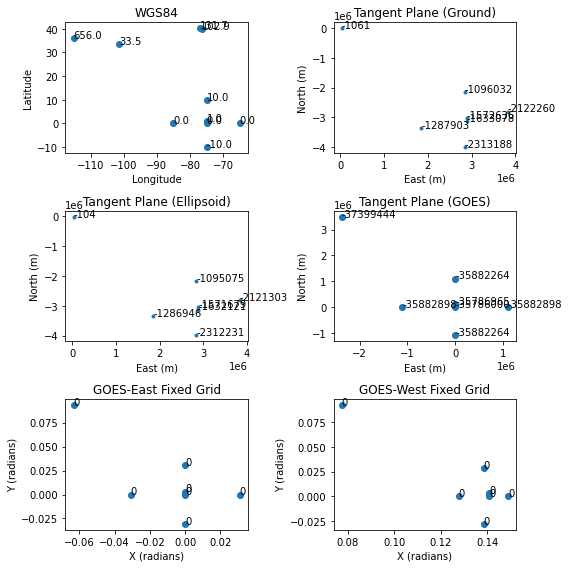

In [5]:
#convert all points into each of the coordinate systems

# Hometown: Mechanicsburg, PA (40.208536505152416, -76.98323567166341) 
   # alt (elev): 131.7m (432.1 ft)
# Undergraduate institution: Millersville Univ Millersville, PA (39.99896278744981, -76.3527070135431)
   # alt elev: 102.9m (337.7 ft)
# Farthest I've been from home: Las Vegas, NV Luxor Hotel & Casino (36.09583076294226, -115.17608865779495)
   # alt elev: 656.0m (2152.1 ft)

loc_lon = ([-76.9832, -76.3527, -115.1761]) # Mech, Ville, LV lons
loc_lat = ([40.2085, 39.9990, 36.0958])     # Mech, Ville, LV lats
loc_alt = ([131.7, 102.9, 656.0])           # Mech, Ville, LV alts

# Stacking with original dataset
all_lon= np.concatenate([lon, loc_lon])
all_lat= np.concatenate([lat, loc_lat])
all_alt= np.concatenate([lat, loc_alt])

# Making the transformations (restating)
# Tan planes
enu_ground= np.vstack(tp_mcom_ground.fromECEF(X, Y, Z)).T
enu_ellipsoid= np.vstack(tp_mcom_ellipsoid.fromECEF(X, Y, Z)).T
#enu_alt= enu_mcom_ground/enu_mcom_ellipsoid

# GOES fixed
fg_east= np.vstack(goes_east.fromECEF(X, Y, Z)).T
fg_west= np.vstack(goes_west.fromECEF(X, Y, Z)).T


# Making the plots
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8))

# WGS84
axes[0,0].plot(all_lon, all_lat, 'o')
for tlon, tlat, tlabel in zip(all_lon, all_lat, all_alt):
    axes[0,0].text(tlon, tlat, str(tlabel))
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')
axes[0,0].set_title('WGS84')


# Make the other five panels here

# TP (ground)
axes[0,1].plot(enu_mcom_ground[:, 0], enu_mcom_ground[:, 1],
               marker='.', linestyle='none')
for x, y, z in enu_mcom_ground: 
    axes[0, 1].text(x, y, f"{z:.0f}")
axes[0,1].set_xlabel("East (m)")
axes[0,1].set_ylabel("North (m)")
axes[0,1].set_title("Tangent Plane (Ground)")


#TP (ellipsoid)
axes[1,0].plot(enu_mcom_ellipsoid[:, 0], enu_mcom_ellipsoid[:, 1], 
               marker='.', linestyle='none')
for x, y, z in enu_mcom_ellipsoid: 
    axes[1, 0].text(x, y, f"{z:.0f}")
axes[1, 0].set_xlabel("East (m)")
axes[1, 0].set_ylabel("North (m)")
axes[1, 0].set_title("Tangent Plane (Ellipsoid)")


#TP (GOES)
axes[1, 1].plot(enu_goes[:, 0], enu_goes[:, 1], 'o')
for x, y, z in enu_goes: 
    axes[1, 1].text(x, y, f"{z:.0f}")
axes[1, 1].set_xlabel("East (m)")
axes[1, 1].set_ylabel("North (m)")
axes[1, 1].set_title("Tangent Plane (GOES)")

#GOES-E fixed
axes[2, 0].plot(fg_east[:, 0], fg_east[:, 1], 'o')
for x, y in zip(fg_east[:, 0], fg_east[:, 1]):
    axes[2, 0].text(x, y, f"{0}")     # no alt
axes[2, 0].set_xlabel("X (radians)")
axes[2, 0].set_ylabel("Y (radians)")
axes[2, 0].set_title("GOES-East Fixed Grid")

#GOES-W fixed
axes[2, 1].plot(fg_west[:, 0], fg_west[:, 1], 'o')
for x, y in zip(fg_west[:, 0], fg_west[:, 1]):
    axes[2, 1].text(x, y, f"{0}")
axes[2, 1].set_xlabel("X (radians)")
axes[2, 1].set_ylabel("Y (radians)")
axes[2, 1].set_title("GOES-West Fixed Grid")
    
fig.tight_layout()

Answer: All coordinate systems appear to be correct. The points appear to be in the same locations or in the same layout, but are transformed differently based on which plane they are in.

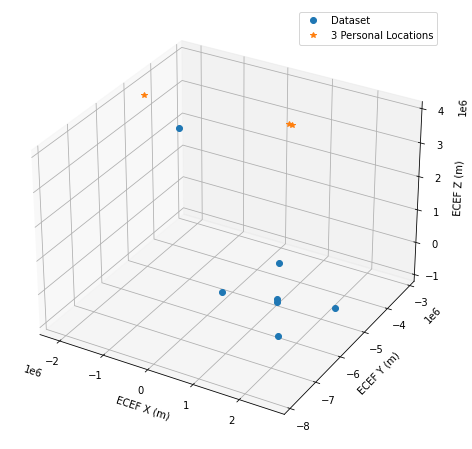

In [9]:
# BONUS! Make a 3D plot of all locations. 
# Try to imagine the curved earth surface on which they reside.
# This part is not graded, but might be useful to you.

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Converting 3 locations to ECEF and making sure 1D arrays
X, Y, Z = geodetic_to_ecef(lat, lon, alt)
locX, locY, locZ = geodetic_to_ecef(loc_lat, loc_lon, loc_alt)


ax.plot(X, Y, Z, marker='o', linestyle='none', label= "Dataset") # original locations
ax.plot(locX, locY, locZ, marker='*', linestyle='none', label= "3 Personal Locations") # personal locations
ax.set_xlabel('ECEF X (m)')
ax.set_ylabel('ECEF Y (m)')
ax.set_zlabel('ECEF Z (m)')
ax.legend()

# Combining both sets of points
allX= np.concatenate([X, locX])
allY= np.concatenate([Y, locY])
allZ= np.concatenate([Z, locZ])

# Fixing aspect ratio
max_range= np.array([allX.max()-allX.min(), allY.max()-allY.min(),
                           allZ.max()-allZ.min()]).max()/ 2.0
mid_x = (allX.max() + allX.min())*0.5
mid_y = (allY.max() + allY.min())*0.5
mid_z = (allZ.max() + allZ.min())*0.5

# Setting the aspect ratio equal
ax.set_xlim(mid_x-max_range, mid_x+max_range)
ax.set_ylim(mid_y-max_range, mid_y+max_range)
ax.set_zlim(mid_z-max_range, mid_z+max_range)

plt.show()

**5.** Using the lon, lat, and data arrays you created in the previous assignment, create a `pcolormesh` plot of the data in geostationary coordinates from both the GOES East and GOES West positions. (15 pts.)

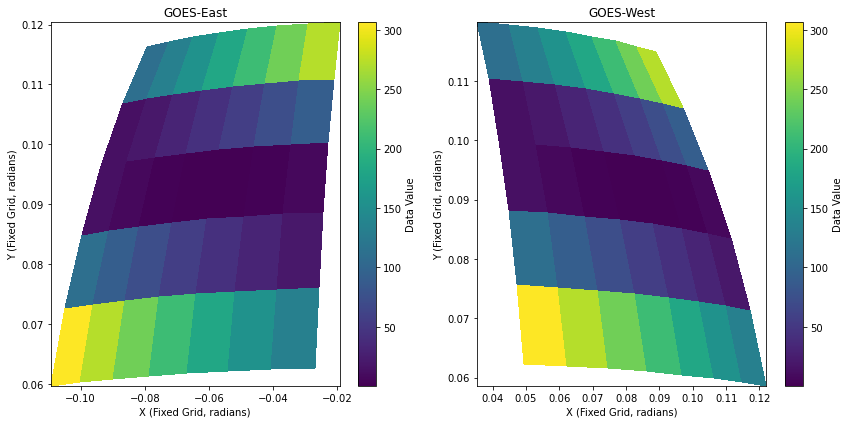

In [10]:
# From HW 1

import matplotlib.pyplot as plt
import numpy as np

mcom_lon, mcom_lat = -101.8803718553, 33.5818617015
mcom_alt = 957.179

nlon = 7
nlat = 5
dlon, dlat = 5.0, 5.0

d = (np.arange(nlon*nlat) - (nlon*nlat/2.0))**2.0
d.shape = (nlat, nlon)

#lon/lat centers
lon = mcom_lon + (np.arange(nlon) - nlon // 2) * dlon    # 33°34'54.9"N 101°52'51.2"W 
lat = mcom_lat + (np.arange(nlat) - nlat // 2) * dlat

# Converting centers to edges
def centers_to_edges_1d(x):
    """Creating function for converting 1D array to edge positions."""
    x= np.asarray(x)
    dx= np.diff(x)
    
    start= x[0]-dx[0]/2    # Fixing edge positons using closest spacing
    end= x[-1]+dx[-1]/2
    
    edges= x[:-1]+dx/2    # midpoints between each center for the inside edges
    return np.concatenate([[start], edges, [end]]) #concatenating start, internal edges, and the end

lon_edge = centers_to_edges_1d(lon)
lat_edge = centers_to_edges_1d(lat)

lon_edge_2d, lat_edge_2d= np.meshgrid(lon_edge, lat_edge, indexing= 'xy')

# Importing coord systems
from coords import GeographicSystem, GeostationaryFixedGridSystem

geo= GeographicSystem()

# GOES params
sat_alt= 35786023.0   #alt (m)
goes_east= GeostationaryFixedGridSystem(subsat_lon= -75.0, sat_ecef_height= sat_alt) # -75 deg lon
goes_west= GeostationaryFixedGridSystem(subsat_lon= -137.0, sat_ecef_height= sat_alt) #-137 deg lon


# Converting to ECEF then to GOES coords
lon2d, lat2d= np.meshgrid(lon_edge, lat_edge, indexing= 'xy')
X, Y, Z= geo.toECEF(lon2d, lat2d, np.zeros_like(lon2d)) #alt is 0

# Project into East/West coords (fixed)
Xe, Ye, Ze= goes_east.fromECEF(X, Y, Z)
Xw, Yw, Zw= goes_west.fromECEF(X, Y, Z)


# PLotting
fig, axes= plt.subplots(1, 2, figsize= (12, 6))

# GOES-East
pcm1= axes[0].pcolormesh(Xe, Ye, d, cmap= 'viridis', shading= "auto")
axes[0].set_title("GOES-East")
fig.colorbar(pcm1, ax= axes[0], label= "Data Value")

# GOES-West
pcm2= axes[1].pcolormesh(Xw, Yw, d, cmap= 'viridis', shading= "auto")
axes[1].set_title("GOES-West")
fig.colorbar(pcm2, ax= axes[1], label= "Data Value")

for ax in axes:
    ax.set_xlabel("X (Fixed Grid, radians)")
    ax.set_ylabel("Y (Fixed Grid, radians)")
    
plt.tight_layout()
plt.show()

**6.** One thing we didn't do in the previous assignment was plot in a "traditional" map projection. We'll do that now with the Azimuthal Equidistant and Gnomonic projections, centered on MCOM, as defined below. The MapProjection class has the same to/from ECEF methods, and coordinates returned are in meters relative to the center point. (15 pts.)

If you're curious, you can peruse [the full list of projections](https://proj.org/operations/projections/index.html) to see how to define others.

Create a pcolor plot of the same data from the last homework in each map projection, and set the axis limits to +/- 1600 km. Do you notice any differences in the two projections?

C:\Users\melmo\AppData\Local\Temp\ipykernel_21196\1870343030.py:40: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc1= axs[0].pcolormesh(Xa/1000, Ya/1000, d, shading= 'auto', cmap= 'viridis')
C:\Users\melmo\AppData\Local\Temp\ipykernel_21196\1870343030.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc2= axs[1].pcolormesh(Xg/1000, Yg/1000, d, shading= 'auto', cmap= 'viridis')


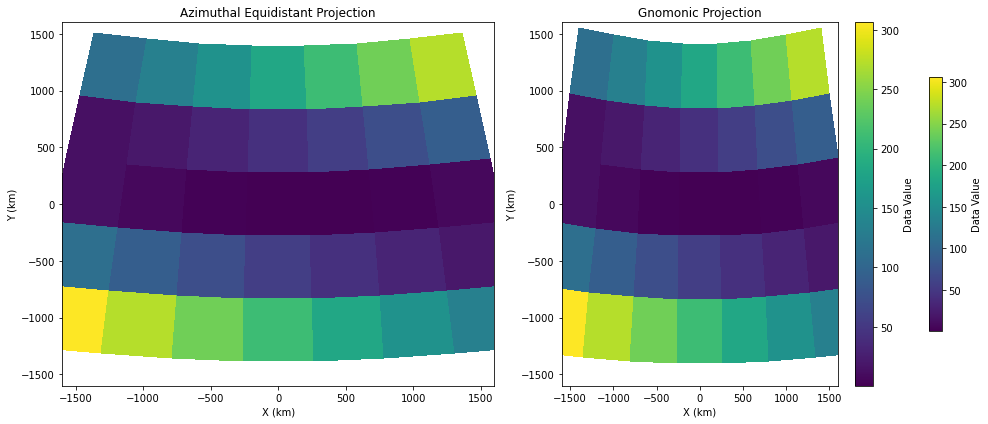

In [11]:
from coords import MapProjection

# MCOM coords
mcom_lon, mcom_lat= -101.8803718553, 33.5818617015

# Restating data
nlon, nlat= 7, 5
dlon, dlat= 5.0, 5.0

d = (np.arange(nlon * nlat) - (nlon * nlat / 2.0))**2.0
d.shape = (nlat, nlon)

lon = mcom_lon + (np.arange(nlon) - nlon // 2) * dlon
lat = mcom_lat + (np.arange(nlat) - nlat // 2) * dlat

# Convert lon/lat centers to 2D grids
lon2d, lat2d = np.meshgrid(lon, lat, indexing='xy')
aeqd = MapProjection(projection='aeqd', lon_0=mcom_lon, lat_0=mcom_lat)
gnom = MapProjection(projection='gnom', lon_0=mcom_lon, lat_0=mcom_lat)

X, Y, Z= geo.toECEF(lon2d, lat2d, np.zeros_like(lon2d)) #alt is 0

# Project into AEQD and GNOM
Xa, Ya, Za= aeqd.fromECEF(X, Y, Z)  # map plane coords (m)
Xg, Yg, Zg= gnom.fromECEF(X, Y, Z)

# Converting centers to edges
Xa_edges = centers_to_edges_1d(Xa[0, :])
Ya_edges = centers_to_edges_1d(Ya[:, 0])
Xg_edges = centers_to_edges_1d(Xg[0, :])
Yg_edges = centers_to_edges_1d(Yg[:, 0])

# Making 2D edge grids
Xa2d, Ya2d = np.meshgrid(Xa_edges, Ya_edges)
Xg2d, Yg2d = np.meshgrid(Xg_edges, Yg_edges)

fig, axs= plt.subplots(1, 2, figsize= (14, 6))

# Azimuthal equidistant
pc1= axs[0].pcolormesh(Xa/1000, Ya/1000, d, shading= 'auto', cmap= 'viridis')
axs[0].set_title("Azimuthal Equidistant Projection")
axs[0].set_xlim([-1600, 1600])
axs[0].set_ylim([-1600, 1600])
axs[0].set_xlabel("X (km)")
axs[0].set_ylabel("Y (km)")
fig.colorbar(pc1, ax= axs[1], shrink= 0.7, label= "Data Value")

# Gnomonic
pc2= axs[1].pcolormesh(Xg/1000, Yg/1000, d, shading= 'auto', cmap= 'viridis')
axs[1].set_title("Gnomonic Projection")
axs[1].set_xlim([-1600, 1600])
axs[1].set_ylim([-1600, 1600])
axs[1].set_xlabel("X (km)")
axs[1].set_ylabel("Y (km)")
fig.colorbar(pc2, ax= axs[1], orientation= 'vertical', label= "Data Value")

plt.tight_layout()
plt.show()